In [1]:
!pip install --upgrade numpy==1.17.5
# !pip install pandas==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.0 MB 951 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.20.2 requires numpy>=1.18, but you have numpy 1.17.5 which is incompatible.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.17.5 which is incompatible.
tensorflow 2.9.2 requires numpy>=1.20, but you have numpy 1.17.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.17.5 which is incompatible.
plotnine 0.8.0 requires numpy>=1.19.0, but you have numpy 1.17.5 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.17.5 which is i

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from tqdm.notebook import tqdm

import random
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nnd
from torch.utils.data import DataLoader

In [2]:
np.__version__

'1.17.5'

In [75]:
IMAGE_SIZE = 320
BATCH_SIZE = 7
EPOCHS = 25

color_dict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL project/Land Cover Classification/Data/class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [76]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("/content/drive/MyDrive/Colab Notebooks/DL project/Land Cover Classification/Data/train/*.jpg")), 
    'MASKS': sorted(glob("/content/drive/MyDrive/Colab Notebooks/DL project/Land Cover Classification/Data/train/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

,IMAGES,MASKS
0,/content/drive/MyDrive/Colab Notebooks/DL proj...,/content/drive/MyDrive/Colab Notebooks/DL proj...
1,/content/drive/MyDrive/Colab Notebooks/DL proj...,/content/drive/MyDrive/Colab Notebooks/DL proj...
2,/content/drive/MyDrive/Colab Notebooks/DL proj...,/content/drive/MyDrive/Colab Notebooks/DL proj...
3,/content/drive/MyDrive/Colab Notebooks/DL proj...,/content/drive/MyDrive/Colab Notebooks/DL proj...
4,/content/drive/MyDrive/Colab Notebooks/DL proj...,/content/drive/MyDrive/Colab Notebooks/DL proj...


In [77]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(pd_dataset, test_size=0.10, random_state=42)
pd_train, pd_val = train_test_split(pd_train, test_size=0.10, random_state=42)

print("Training set size:", len(pd_train))
print("Validation set size:", len(pd_val))
print("Testing set size:", len(pd_test))

Training set size: 649
Validation set size: 73
Testing set size: 81


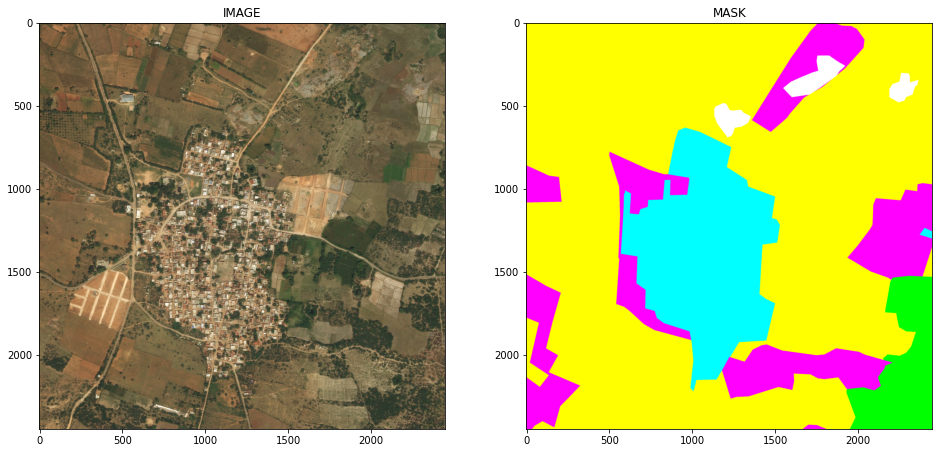

In [78]:
index = 0

sample_img = cv2.imread(pd_train.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_train.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

In [79]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

In [80]:
from PIL import Image

CATS = np.array([0,1,2,3,4,5,6])
m = Image.open(pd_train.iloc[index].MASKS)
m = np.array(m)
m = rgb2category(m)
obj_ids = CATS
masks = m == obj_ids[:, None, None]
print(masks.shape)

(7, 2448, 2448)


In [81]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

CATS = np.array([0,1,2,3,4,5,6])

class SegmentationDataset(Dataset):
    def __init__(self, df, transforms=None, preprocessing=None):
        self.df = df
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[index]
        img_path = row.IMAGES
        mask_path = row.MASKS
        img = Image.open(img_path).convert("RGB")
        img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
#         img = np.array(img)
#         img = torch.from_numpy(img)
        mask = Image.open(mask_path)
        mask = mask.resize((IMAGE_SIZE, IMAGE_SIZE))
        mask = np.array(mask)
        mask = rgb2category(mask)
        obj_ids = CATS

        masks = mask == obj_ids[:, None, None]
#         print("Masks shape: ", masks.shape)
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
#             print("POS: ", pos)
            if not np.any(pos):
                boxes.append([0,0,1,1])
                continue
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [82]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def build_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [11]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 258514, done.
remote: Counting objects: 100% (11301/11301), done.
remote: Compressing objects: 100% (717/717), done.
remote: Total 258514 (delta 10637), reused 11139 (delta 10562), pack-reused 247213
Receiving objects: 100% (258514/258514), 522.44 MiB | 34.87 MiB/s, done.
Resolving deltas: 100% (235437/235437), done.
/content/vision
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version


In [12]:
# !pip3 install -U scikit-image
!pip3 install -U cython 
!pip3 install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-install-k90b33lt/pycocotools_31243d4f30d2438b86cfc8ac5067b4cc
  Running command git clone -q https://github.com/philferriere/cocoapi.git /tmp/pip-install-k90b33lt/pycocotools_31243d4f30d2438b86cfc8ac5067b4cc
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=266058 sha256=0162d5432a99f3df8b76787a19df2345eec32b442ada2d7ba8da0193a39fb9f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-u_dpvr_2/wheels/6b/c6/c5/cb6da4cb793a6cb1ab91f6578d76c42686422127eb4dbcea94
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


In [13]:
pip uninstall pycocotools

Found existing installation: pycocotools 2.0
Uninstalling pycocotools-2.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pycocotools-2.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pycocotools/*
Proceed (y/n)? y
  Successfully uninstalled pycocotools-2.0


In [14]:
pip install pycocotools --no-binary pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=267081 sha256=f721bae8e8f408f04a1f15c30eafe5c4ce7d76bae5bc329306021a1ab862c153
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools


In [84]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
#         transforms.append(T.Resize(IMAGE_SIZE, IMAGE_SIZE))
        transforms.append(T.RandomHorizontalFlip(0.5))
#         transforms.append(T.RandomVerticalFlip(0.5))
#         transforms.append(T.RandomAutocontrast(0.5))
    return T.Compose(transforms)


dataset = SegmentationDataset(pd_train, get_transform(train=True))
dataset_test = SegmentationDataset(pd_val, get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [85]:
img, target = next(iter(data_loader))

In [86]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 7

model = build_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [23]:
# number of epochs
num_epochs = 4

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/325]  eta: 1:02:54  lr: 0.000020  loss: 6.1753 (6.1753)  loss_classifier: 1.8083 (1.8083)  loss_box_reg: 0.1601 (0.1601)  loss_mask: 1.3066 (1.3066)  loss_objectness: 2.4035 (2.4035)  loss_rpn_box_reg: 0.4968 (0.4968)  time: 11.6138  data: 1.9487  max mem: 1640
Epoch: [0]  [ 10/325]  eta: 0:07:58  lr: 0.000175  loss: 5.1093 (4.8554)  loss_classifier: 1.5935 (1.5103)  loss_box_reg: 0.1775 (0.1917)  loss_mask: 0.9433 (0.9678)  loss_objectness: 1.9821 (1.7319)  loss_rpn_box_reg: 0.4808 (0.4538)  time: 1.5180  data: 0.1945  max mem: 1917
Epoch: [0]  [ 20/325]  eta: 0:05:19  lr: 0.000329  loss: 2.2648 (3.2604)  loss_classifier: 0.7943 (1.0156)  loss_box_reg: 0.2341 (0.2258)  loss_mask: 0.5173 (0.7057)  loss_objectness: 0.2563 (0.9340)  loss_rpn_box_reg: 0.3766 (0.3793)  time: 0.5187  data: 0.0211  max mem: 1917
Epoch: [0]  [ 30/325]  eta: 0:04:19  lr: 0.000483  loss: 1.1499 (2.5452)  loss_classifier: 0.3672 (0.8053)  loss_box_reg: 0.2665 (0.2450)  loss_mask: 0.2860 (0.5362)

In [24]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/DL project/Land Cover Classification')
torch.save(model, 'mask-rcnn-land_try_epoch4.pt')

In [25]:
# number of epochs
num_epochs = 6

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model, 'mask-rcnn-land_try_epoch10.pt')

Epoch: [0]  [  0/325]  eta: 0:14:03  lr: 0.000020  loss: 0.0636 (0.0636)  loss_classifier: 0.0093 (0.0093)  loss_box_reg: 0.0101 (0.0101)  loss_mask: 0.0438 (0.0438)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 2.5939  data: 2.0125  max mem: 1961
Epoch: [0]  [ 10/325]  eta: 0:03:52  lr: 0.000175  loss: 0.0606 (0.0619)  loss_classifier: 0.0050 (0.0056)  loss_box_reg: 0.0101 (0.0110)  loss_mask: 0.0438 (0.0439)  loss_objectness: 0.0003 (0.0014)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.7384  data: 0.2033  max mem: 1961
Epoch: [0]  [ 20/325]  eta: 0:03:17  lr: 0.000329  loss: 0.0597 (0.0609)  loss_classifier: 0.0046 (0.0052)  loss_box_reg: 0.0101 (0.0109)  loss_mask: 0.0438 (0.0438)  loss_objectness: 0.0003 (0.0010)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5501  data: 0.0212  max mem: 1961
Epoch: [0]  [ 30/325]  eta: 0:03:02  lr: 0.000483  loss: 0.0616 (0.0614)  loss_classifier: 0.0041 (0.0052)  loss_box_reg: 0.0100 (0.0113)  loss_mask: 0.0438 (0.0439) 

In [26]:
# number of epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model, 'mask-rcnn-land_try_epoch15.pt')

Epoch: [0]  [  0/325]  eta: 0:17:33  lr: 0.000020  loss: 0.0504 (0.0504)  loss_classifier: 0.0045 (0.0045)  loss_box_reg: 0.0077 (0.0077)  loss_mask: 0.0381 (0.0381)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 3.2407  data: 2.6719  max mem: 1961
Epoch: [0]  [ 10/325]  eta: 0:04:01  lr: 0.000175  loss: 0.0522 (0.0532)  loss_classifier: 0.0063 (0.0061)  loss_box_reg: 0.0077 (0.0090)  loss_mask: 0.0381 (0.0379)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.7652  data: 0.2633  max mem: 1961
Epoch: [0]  [ 20/325]  eta: 0:03:21  lr: 0.000329  loss: 0.0514 (0.0526)  loss_classifier: 0.0057 (0.0060)  loss_box_reg: 0.0077 (0.0083)  loss_mask: 0.0381 (0.0380)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5309  data: 0.0353  max mem: 1961
Epoch: [0]  [ 30/325]  eta: 0:03:04  lr: 0.000483  loss: 0.0521 (0.0537)  loss_classifier: 0.0060 (0.0064)  loss_box_reg: 0.0107 (0.0092)  loss_mask: 0.0378 (0.0378) 

In [16]:
color_dict

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


In [88]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/DL project/Land Cover Classification')
model = torch.load("mask-rcnn-land_try_epoch15.pt")

In [89]:
# set to evaluation mode
model.eval()
CLASS_NAMES = ['urban_land', 'agriculture_land','rangeland', 'forest_land','water','barren_land','unknown']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [90]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    print("Colored mask: ", coloured_mask.shape)
    return coloured_mask

def get_prediction(img_path, confidence):
    img = Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE))
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = []
    for idx,x in enumerate(pred_score):
        if x>confidence:
            pred_t.append(idx)
    pred_t = pred_t[-1]
    masks = (pred[0]['masks']>0.75).squeeze().detach().cpu().numpy()
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=0.72, text_th=1):
    masks, boxes, pred_cls = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(IMAGE_SIZE, IMAGE_SIZE))
    print("IMG:", img.shape)
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
      x1,y1 = boxes[i][0]
      x2,y2 = boxes[i][1]
      cv2.rectangle(img, (int(x1),int(y1)), (int(x2), int(y2)),color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], (int(x1)+20,int(y1)+20), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

IMG: (320, 320, 3)
Colored mask:  (320, 320, 3)


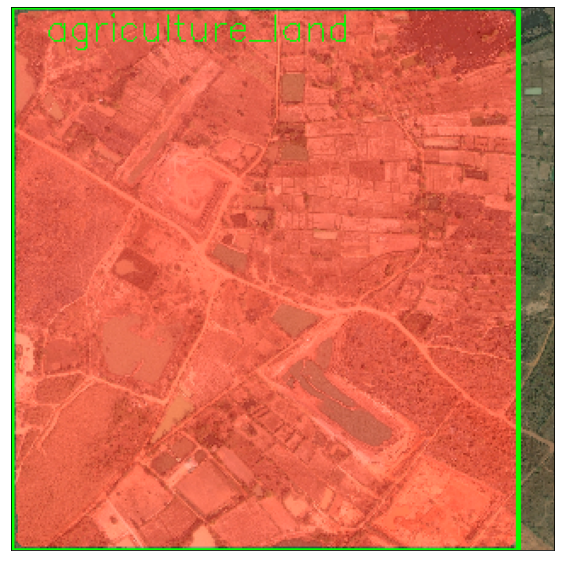

In [91]:
segment_instance('/content/drive/MyDrive/Colab Notebooks/DL project/Land Cover Classification/Data/train/120245_sat.jpg', confidence=0.75)

IMG: (320, 320, 3)
Colored mask:  (320, 320, 3)
Colored mask:  (320, 320, 3)


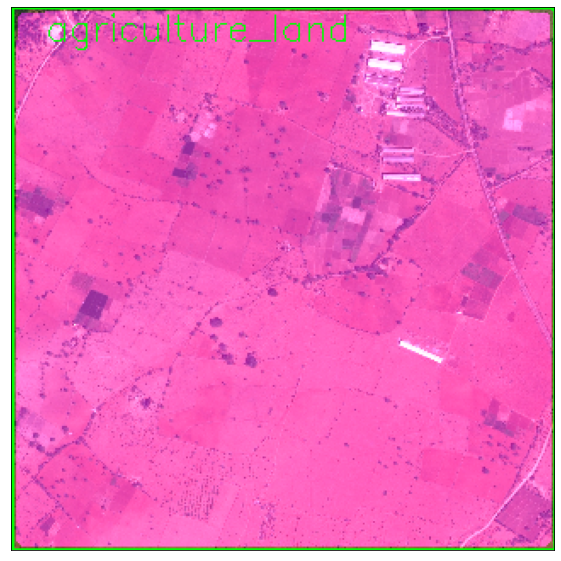

In [92]:
segment_instance('/content/drive/MyDrive/Colab Notebooks/DL project/Land Cover Classification/Data/train/147545_sat.jpg', confidence=0.75)

IMG: (320, 320, 3)
Colored mask:  (320, 320, 3)


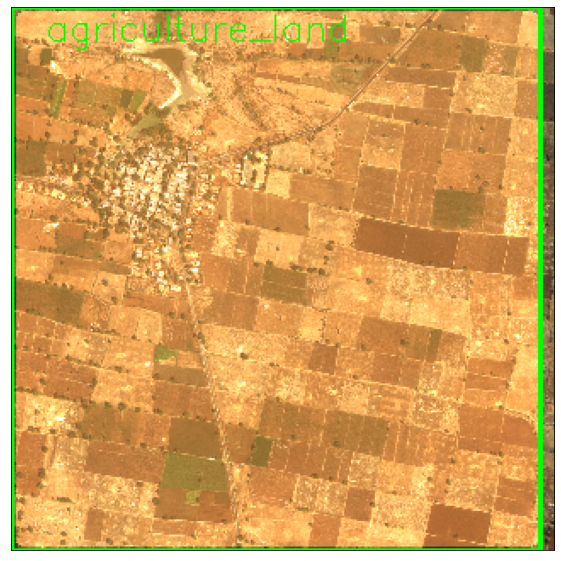

In [93]:
segment_instance('/content/drive/MyDrive/Colab Notebooks/DL project/Land Cover Classification/Data/train/511850_sat.jpg', confidence=0.75)